# Chapter 16 - Natural Language Processing: Applications

Given pretrained text representations, we will explore how sentiment analysis and natural language inference can be accomplished in practice.

![](../imgs/ch16/nlp-map-app.svg)

## 16.1. Sentiment Analysis and the Dataset

The *sentiment analysis* task aims to study people's sentiments in their produced text, such as product reviews, blog comments, and forum discussions. It enjoys wide applications to fields as diverse as politics (e.g., analysis of public sentiments towards policies), finance (e.g., analysis of sentiments of the market), and marketing (e.g., product research and brand management).

Sentiment analysis can be considered as a text classification task, which *transforms a varying-length text sequence into a fixed-length text category*.

In [1]:
import os
import torch
import torch.nn as nn

from d2l import torch as d2l

### 16.1.1. Reading the Dataset

In [2]:
d2l.DATA_HUB['aclImdb'] = (d2l.DATA_URL + 'aclImdb_v1.tar.gz',
                          '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

Next, read the training and test datasets.

Each example is a review and its corresponding sentiment label: 1 for "positive" and 0 for "negative".

In [3]:
def read_imdb(data_dir, is_train):
    '''Read the IMDb review dataset text sequences and labels'''
    data, labels = [], []

    for label in ('pos', 'neg'):
        folder_name = os.path.join(
            data_dir,
            'train' if is_train else 'test',
            label
        )

        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                # Each review is stored as a single line of text
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    
    return data, labels

In [4]:
train_data = read_imdb(data_dir, is_train=True)
print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[:60])

# trainings: 25000
label: 1 review: Bromwell High is a cartoon comedy. It ran at the same time a
label: 1 review: Homelessness (or Houselessness as George Carlin stated) has 
label: 1 review: Brilliant over-acting by Lesley Ann Warren. Best dramatic ho


### 16.1.2. Preprocessing the Dataset

Treating each word as a token and filtering out words that appear less than 5 times.

In [6]:
# tokenize the text into words
train_tokens = d2l.tokenize(train_data[0], token='word')
# create a vocabulary
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

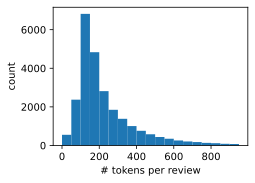

In [7]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist(
    [len(line) for line in train_tokens],
    bins=range(0, 1000, 50)
);

The reviews have different numbers of tokens. To process a minibatch of such reviews at each time, we set the length of each review to 500 with truncation and padding.

In [8]:
num_steps = 500 # sequence length

train_features = torch.tensor(
    [d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']
    ) for line in train_tokens]
)
print(train_features.shape)

torch.Size([25000, 500])


### 16.1.3. Creating the Data Iterator

In [9]:
train_iter = d2l.load_array(
    data_arrays=(train_features, torch.tensor(train_data[1])),
    batch_size=64
)

In [10]:
for X, y in train_iter:
    print('review shape:', X.shape, ', label shape:', y.shape)
    break

print('# batches:', len(train_iter))

review shape: torch.Size([64, 500]) , label shape: torch.Size([64])
# batches: 391


### 16.1.4. Putting It All Together

The `load_data_imdb` function wraps up all the preceding steps and returns the data iterators and the vocabulary of the IMDb review dataset.

In [11]:
def load_data_imdb(batch_size, num_steps=500):
    '''Return data iterator and vocabulary of the IMDb review dataset'''
    # download and read the IMDB review dataset
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)

    # tokenize the text into words
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    # create a vocabulary of tokens
    vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])
    # truncate and pad text sequences
    train_features = torch.tensor(
        [d2l.truncate_pad(
            vocab[line], num_steps, vocab['<pad>']
        ) for line in train_tokens]
    )
    test_features = torch.tensor(
        [d2l.truncate_pad(
            vocab[line], num_steps, vocab['<pad>']
        ) for line in test_tokens]
    )

    # create data iterators
    train_iter = d2l.load_array(
        data_arrays=(train_features, torch.tensor(train_data[1])),
        batch_size=batch_size
    )
    test_iter = d2l.load_array(
        data_arrays=(test_features, torch.tensor(test_data[1])),
        batch_size=batch_size,
        is_train=False
    )

    return train_iter, test_iter, vocab

## 16.2. Sentiment Analysis: Using RNNs

In this section, we will follow the diagram below to represent each token using the pretrained GloVe model in the IMDb review dataset, and feed these token representations into a multiplayer bidrectional RNN to obtain the text sequence representation, which will then be transformed into sentiment analysis outputs.

![](../imgs/ch16/nlp-map-sa-rnn.svg)

In [1]:
import torch
from torch import nn

from d2l import torch as d2l

In [2]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

### 16.2.1. Representing Single Text with RNNs

In text classifications tasks, such as sentiment analysis, a varying-length text sequence will be transformed into fixed-length categories.

In the `BiRNN` class, while each token of a text sequence gets its individual pretrained GloVe representation via the embedding layer (`self.embedding`), the entire sequence is encoded by a bidirectional RNN (`self.encoder`).

The hidden states (at the last layer) of the bidirecitonal LSTM at both the initial and final time steps are concatenated as the representation of the text sequence. This single text representation is then transformed into output categories by a fully-connected layer (`self.decoder`) with two outputs ("positive" and "negative").

In [3]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)

        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embed_size)
        
        # set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(
            input_size=embed_size,
            hidden_size=num_hiddens,
            num_layers=num_layers,
            bidirectional=True
        )
        self.decoder = nn.Linear(in_features=4*num_hiddens,
                                 out_features=2)
        
    def forward(self, inputs):
        # The shape of `inputs` is (batch size, num_steps).
        # Because LSTM requires its input's first dimension to be
        # the temporal dimension, the input is transposed before
        # obtaining token representations.
        # The output shape is (num_steps, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)

        self.encoder.flatten_parameters()
        # Return hidden states of the last hidden layer at different time steps.
        # The shape of `outputs` is (num_steps, batch size, 2 * num_hiddens).
        outputs, _ = self.encoder(embeddings)

        # Concatenate the hidden states at the initial and final time steps 
        # as the input of the fully-connected layer.
        # Its shape is (batch size, 4 * num_hiddens)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=-1)
        outs = self.decoder(encoding)

        return outs

Now we can construct a directional RNN with 2 hidden layers to represent single text for sentiment analysis.

In [4]:
embed_size = 100
num_hiddens = 100
num_layers = 2
devices = d2l.try_all_gpus()

net = BiRNN(vocab_size=len(vocab),
            embed_size=embed_size,
            num_hiddens=num_hiddens,
            num_layers=num_layers)

def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if 'weight' in param:
                nn.init.xavier_uniform_(module._parameters[param])

# apply the initializer to all the weights of model
net.apply(init_weights);

### 16.2.2. Loading Pretrained Word Vectors

We need to load the pretrained 100-dimensional (**needs to be consistent with** `embed_size`) GloVe embeddings for tokens in the vocabulary.

In [5]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

We can use these pretrained word vectors to represent tokens in the reviews and will not update these vectors during training.

In [6]:
# set the embedding layer's weight to pretrained embedding `embeds`
net.embedding.weight.data.copy_(embeds)
# set the embedding layer not to update during training
net.embedding.weight.requires_grad = False

### 16.2.3. Training and Evaluation the Model

In [7]:
lr = 0.01
num_epochs = 5

trainer = torch.optim.Adam(net.parameters(), lr=lr)

loss = nn.CrossEntropyLoss(reduction='none')

loss 0.307, train acc 0.869, test acc 0.848
320.4 examples/sec on [device(type='cuda', index=0)]


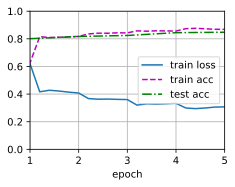

In [8]:
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [9]:
def predict_sentiment(net, vocab, sequence):
    '''Predict the sentiment of a text sequence'''
    sequence = torch.tensor(vocab[sequence.split()],
                            device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)),
                         dim=1)
    
    return 'positive' if label == 1 else 'negative'

We can now use the trained model to predict the sentiment for two simple sentences.

In [10]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [11]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## 16.3. Sentiment Analysis: Using CNNs

Though originally designed for computer vision, CNNs are also widely used for natural language processing. We can think of any text sequence as a one-dimensional image. In this way, one-dimensional CNNs can process local features such as $n$-grams in text.

In this section, we will use the *textCNN* model to demonstrate how to design a CNN architecture for representing single text, following the diagram below.

![](../imgs/ch16/nlp-map-sa-cnn.svg)

In [12]:
import torch
from torch import nn

from d2l import torch as d2l

In [13]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

### 16.3.1. One-Dimensional Convolutions

![](../imgs/ch16/conv1d.svg)

In the figure above, the convolution window in 1D case slides from left to right across the input tensor.

The `corr1d` functrion is used to compute the 1D cross-correlation, given an input tensor `X` and a kernel tensor `K`.

In [14]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i : i + w] * K).sum()
    
    return Y

In [15]:
# test
X = torch.tensor([0, 1, 2, 3, 4, 5, 6])
K = torch.tensor([1, 2])

corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

For a one-dimensional input with multiple channels, the convolution kernel needs to have the same number of input channels. For each channel, we perform a cross-correlation on the one-dimensional tensor of the input and the one-dimensional tensor of the kernel, summing the results over all the channels to produce the one-dimensional output tensor, as shown in the figure below.

![](../imgs/ch16/conv1d-channel.svg)

In [16]:
def corr1d_multi_in(X, K):
    # Iterate through the 0th dimension (channel dimension) of `X` and `K`
    # Then, add them together
    res = [corr1d(x, k) for x,k in zip(X, K)]
    return sum(res)

In [17]:
# test
X = torch.tensor([
    [0, 1, 2, 3, 4, 5, 6],
    [1, 2, 3, 4, 5, 6, 7],
    [2, 3, 4, 5, 6, 7, 8]
])
K = torch.tensor([
    [1, 2],
    [3, 4],
    [-1, -3]
])

corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

The *multi-input-channel* one-dimensional cross-correlations are equivalent to the *single-input-channel* two-dimensional cross-correlations. An equivalent form of the multi-input-channel one-dimensional cross-correlation, in the figure above, is the *single-input-channel* two-dimensional cross-correlation, shown in the figure below., where the height of the convolution kernel has to be the same as that of the input tensor.

![](../imgs/ch16/conv1d-2d.svg)

### 16.3.2. Max-Over-Time Pooling

We can use pooling to extract the highest value from sequence representations as the most important feature across time steps.

The *max-over-time pooling* used in textCNN works like the one-dimensional global max-pooling.

For a multi-channel input where each channel stores values at different time steps, the output at each channel is the maximum value for that channel. The max-over-time pooling allows different numbers of time steps at different channels.

### 16.3.3. The textCNN Model

The textCNN model uses 1D convolution and max-over-time pooling, takes individual pretrained token representations as input, then obtains and transforms sequence representations for the downstream applications.

For a single text sequence with $n$ tokens represented by $d$-dimensional vectors, the width, height, and number of channels of the input tensors are $n$, 1, and $d$, respectively. The textCNN model transforms the input tensor into the output by:
1. defining multiple one-dimensional convolution kernels and perform convolution operations separately on the inputs. Convolution kernels with different widths may capture local features among different numbers of adjacent tokens.
2. performing max-over-time pooling on all the output channels, and then concatenate all the scalar pooling outputs as a vector.
3. transforming the concatenated vector into the output categories using the fully-connected layer. Dropout can be used to regularize the model.

![](../imgs/ch16/textcnn.svg)

The figure above shows the model architecture of textCNN with a concrete example.

#### 16.3.3.1. Defining the Model

Compared with the bidirectional RNN model in the previous section, we also use two embedding layers: one with trainable weights and the other with fixed pretrained weights.

In [19]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, nums_channels, **kwargs):
        super(TextCNN, self).__init__(**kwargs)

        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embed_size)
        
        # the constant_embedding layer does not participate in training
        self.constant_embedding = nn.Embedding(num_embeddings=vocab_size,
                                               embedding_dim=embed_size)
        
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(nums_channels), 2)

        # the max-over-time pooling layer has no parameters,
        # so this instance can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()

        # create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(nums_channels, kernel_sizes):
            self.convs.append(
                nn.Conv1d(2 * embed_size, c, k)
            )

    def forward(self, inputs):
        # concatenate two embedding layer outputs with shape 
        # (batch size, no. of tokens, word vector dimension) along vectors
        embeddings = torch.cat(
            (self.embedding(inputs),
            self.constant_embedding(inputs)),
            dim=2
        )

        # according to the input format of 1D convolutional layer,
        # rearrange the tensor so that the 2nd dimension stores channels
        embeddings = embeddings.permute(0, 2, 1)

        # for each 1D convolutional layer, after max-over-time pooling,
        # a tensor of shape (batch size, no. of channels, 1) can be obtained.
        # Remove the last dimension and concatenate along the channel dimension
        encoding = torch.cat(
            [torch.squeeze(self.relu(self.pool(conv(embeddings))),
                           dim=-1)
                           for conv in self.convs],
            dim=1
        )

        outputs = self.decoder(self.dropout(encoding))

        return outputs

Create a textCNN instance, which has 3 convolutional layers with kernel widths of 3, 4, and 5, all with 100 output channels.

In [20]:
embed_size = 100
kernel_sizes = [3, 4, 5]
nums_channels = [100, 100, 100]
devices = d2l.try_all_gpus()

net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)

net.apply(init_weights);

#### 16.3.3.2. Loading Pretrained Word Vectors

In [21]:
# load pretrained GloVe embedding
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]

# set the embedding layer's weight to pretrained embedding `embeds`
net.embedding.weight.data.copy_(embeds)
# set the constant_embedding layer's weight to pretrained embedding `embeds`
net.constant_embedding.weight.data.copy_(embeds)
# set the constant_embedding layer not to update during training
net.constant_embedding.weight.requires_grad = False

#### 16.3.3.3. Training and Evaluating the Model

In [22]:
lr = 0.001
num_epochs = 5

trainer = torch.optim.Adam(net.parameters(), lr=lr)

loss = nn.CrossEntropyLoss(reduction='none')

loss 0.066, train acc 0.979, test acc 0.872
974.3 examples/sec on [device(type='cuda', index=0)]


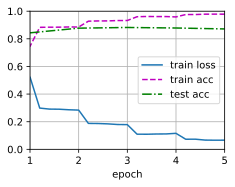

In [23]:
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [24]:
# evaluation
d2l.predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [25]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## 16.4. Natural Language Inference and the Dataset

### 16.4.1. Natural Language Inference

*Natural language inference* (NLI) studies whether a *hypothesis* can be inferred from a *premise*, where both are text squences. The natural language inference determines the logical relationship between a pair of text sequences. Such relationships include:
* *Entailment*: the hypothesis can be inferred from the premise.
* *Contradiction*: the negation of the hypothesis can be inferred from the premise.
* *Neutral*: all other cases.

Natural language inference is also known as the recognizing textual entailment task.

For example, entailment:
* Premise: Two women are hugging each other.
* Hypothesis: Two women are showing affection.

Contradition:
* Premise: A man is running he coding example from Dive into Deep Learning.
* Hypothesis: The man is sleeping.

Neutrality:
* Premise: The musicians are performing for us.
* Hypothesis: The musicians are famous.

### 16.4.1. The Standard Natural Language Inference (SNLI) Dataset

In [3]:
import os
import re
import torch
from torch import nn
from d2l import torch as d2l

In [17]:
d2l.DATA_HUB['SNLI'] = (
    'https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
    '9fcde07509c7e87ec61c640c1b2753d9041758e4')

#data_dir = d2l.download_extract('SNLI')
data_dir = '../data/snli_1.0/snli_1.0'

#### 16.4.2.1. Reading the Dataset

In [27]:
def read_snli(data_dir, is_train):
    '''Read the SNLI dataset in to premies, hypotheses, and labels'''
    def extract_test(s):
        # remove information that will not be used by us
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)

        # substitute two or more consecutive whitespace with space
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()
        

    label_set = {
        'entailment': 0,
        'contradiction': 1,
        'neutral': 2,
    }

    file_name = os.path.join(data_dir,
                             'snli_1.0_train.txt' if is_train else 'snli_1.0_test.txt')
    
    with open(file_name, 'r') as f:
        rows = [
            row.split('\t') for row in f.readlines()[1:]
        ]

    premises = [
        extract_test(row[1]) for row in rows if row[0] in label_set
    ]
    hypotheses = [
        extract_test(row[2]) for row in rows if row[0] in label_set
    ]
    labels = [
        label_set[row[0]] for row in rows if row[0] in label_set
    ]

    return premises, hypotheses, labels

The labels "0", "1", and "2" represent entailment, contradiction, and neutrality, respectively.

In [28]:
train_data = read_snli(data_dir, is_train=True)

for x0, x1, y in zip(train_data[0][:3],
                     train_data[1][:3],
                     train_data[2][:3]):
    print('premise:', x0)
    print('hypothesis:', x1)
    print('label:', y)

premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is training his horse for a competition .
label: 2
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is at a diner , ordering an omelette .
label: 1
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is outdoors , on a horse .
label: 0


In [30]:
test_data = read_snli(data_dir, is_train=False)
for data in [train_data, test_data]:
    # [premise, hypothesis, label]
    print([[row for row in data[2]].count(i) for i in range(3)])

[183416, 183187, 182764]
[3368, 3237, 3219]


#### 16.4.2.2. Defining a Class for Loading the Dataset

The `num_steps` specifies the length of a text sequence so that each minibatch of sequences will have the same shape.
* Tokens after the first `num_steps` ones in long sequence are trimmed.
* Special tokens `"<pad>"` will be appended to shorter sequences until their length becomes `num_steps`.

In [34]:
class SNLIDataset(torch.utils.data.Dataset):
    '''A customized dataset to load the SNLI dataset'''
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps

        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens, # tokens
                                   min_freq=5, # count threshold
                                   reserved_tokens=['<pad>']) # reserve for padding
        else:
            self.vocab = vocab

        # customized pad token indices of premises and hypotheses
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])

        print('Read ' + str(len(self.premises)))

    def _pad(self, lines):
        # truncate or pad each sequence
        return torch.tensor([
            d2l.truncate_pad(self.vocab[line], # token indices
                             self.num_steps, # sequence length
                             self.vocab['<pad>']) # reserved token for padding
         for line in lines])
    
    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]
    
    def __len__(self):
        return len(self.premises)

#### 16.4.2.3. Putting It All Together

We must use the vocabulary constructed from the training set as that of the testing set. As a result, any new token from the testing set will be unknown to the model trained on the training set.

In [35]:
def load_data_snli(batch_size, num_steps=50):
    '''Download the SNLI dataset and return data iterators and vocabulary'''
    num_workers = d2l.get_dataloader_workers()

    # read raw text data from the SNLI dataset
    data_dir = '../data/snli_1.0/snli_1.0'
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)

    # build dataset
    train_set = SNLIDataset(train_data, num_steps, vocab=None)
    test_set = SNLIDataset(test_data, num_steps, vocab=train_set.vocab)

    # build data iterator
    train_iter = torch.utils.data.DataLoader(train_set,
                                             batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_set,
                                            batch_size,
                                            shuffle=False,
                                            num_workers=num_workers)
    
    return train_iter, test_iter, train_set.vocab

In [36]:
batch_size = 128
num_steps = 50

train_iter, test_iter, vocab = load_data_snli(batch_size, num_steps)
len(vocab)

Read 549367
Read 9824


18678

In [37]:
for X, Y in train_iter:
    print(X[0].shape)
    print(X[1].shape)
    print(Y.shape)
    break

## 16.5. Natural Language Inference: Using Attention

![](../imgs/ch16/nlp-map-nli-attention.svg)

The figure above shows the model architecture of the attention-based natural language inference model.

### 16.5.1. The Model

We can align tokens in one text sequence to every token in the other text sequence, and vice versa, and then compare and aggregate such information to predict the logical relationships between premises and hypotheses.

Similar to alignment of tokens between source and target sentences in machine translation, the alignment of tokens between premises and hypotheses can be neatly accomplished by attention mechanisms.

![](../imgs/ch16/nli-attention.svg)

The figure above shows the natural language inference model with attention mechanisms. It consists of three parts:
* attending,
* comparing, and
* aggregating.

In [14]:
import os
import re
import torch
from torch import nn
from torch.nn import functional as F

from d2l import torch as d2l

#### 16.5.1.1. Attending

The first step is to align tokens in one text sequence to each token in the other text sequence.

Suppose that the premise is "I do need sleep" and the hypothesis is "I am tired".

The *soft alignment* uses the attention mechanism to compute the alignment between each token in the premise and each token in the hypothesis. We denote by $\mathbf{A} = (\mathbf{a}_1, \ldots, \mathbf{a}_m)$ and $\mathbf{B} = (\mathbf{b}_1, \ldots, \mathbf{b}_n)$ the premise and hypothesis, whose number of tokens are $m$ and $n$, respectively, where $\mathbf{a}_i, \mathbf{b}_j \in \mathbb{R}^{d}$ are the $d$-dimensional word vectors. For soft alignment, we compute the attention weights $e_{ij} \in \mathbb{R}$ as
\begin{split}
e_{ij} = f(\mathbf{a}_i)^\top f(\mathbf{b}_j),
\end{split}
where the function $f$ is an MLP defined in the `mlp` function below. The output dimension of $f$ is specified by `num_hiddens`.

In [2]:
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())

    if flatten:
        net.append(nn.Flatten(start_dim=1))

    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())

    if flatten:
        net.append(nn.Flatten(start_dim=1))
    
    return nn.Sequential(*net)

Since $\mathbf{A}$ and $\mathbf{B}$ have different numbers of tokens, the function $f$ takes inputs $\mathbf{a}_i$ and $\mathbf{b}_j$ separately rather than takes a pair of them together as input, which leads to only $m+n$ applications of $f$ rather than $mn$ applications.

We also need to normalize the attention weights. We compute the weighted average of all the token vectors in the hypothesis $\mathbf{B}$ to obtain representation of the hypothesis that is softly aligned with the token indexed by $i$ in the premise:
\begin{split}
\boldsymbol{\beta}_i = \sum_{j=1}^{n}\frac{\exp(e_{ij})}{ \sum_{k=1}^{n} \exp(e_{ik})} \mathbf{b}_j.
\end{split}

Similarly, we can compute the weighted average of all the token vectors in the premise $\mathbf{A}$ to obtain representation of the premise that is softly aligned with the token indexed by $j$ in the hypothesis:
\begin{split}
\boldsymbol{\alpha}_j = \sum_{i=1}^{m}\frac{\exp(e_{ij})}{ \sum_{k=1}^{m} \exp(e_{kj})} \mathbf{a}_i.
\end{split}

The `Attend` class is used to compute the soft alignment of hypothesis (`beta`) with input premises `A` and the soft alignment of premise (`alpha`) with input hypothesis `B`:

In [3]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)

        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # Shape of `A`/`B`: (`batch_size`, no. of tokens in seq A/B, `embed_size`)
        # Sahpe of `f_A`/`f_B`: (`batch_size`, no. of tokens in seq A/B, `num_hiddens`)
        f_A = self.f(A)
        f_B = self.f(B)

        # Shape of `e`: (`batch_size`, no. of tokens in seq A, no. of tokens in seq B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1)) # bmm: batch matrix multiplication

        # Shape of `beta`: (`batch_size`, no. of tokens in seq A, `embed_size`),
        # where seq B is softly aligned with each token (dim 1 of `beta`) in seq A
        beta = torch.bmm(F.softmax(e, dim=-1), B)

        # Shape of `alpha`: (`batch_size`, no. of tokens in seq B, `embed_size`),
        # where seq A is softly aligned with each token (dim 1 of `alpha`) in seq B
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)

        return beta, alpha

#### 16.5.1.2. Comparing

Next, we compare a token in one sequence with the other sequence that is softly aligned with that token.

In soft alignment, all the tokens from one sequence, though with probably different attention weights, will be compared with a token in the other sequence.

In the comparing step, we feed the concatenation (operator $[\cdot, \cdot]$) of tokens from one sequence and aligned tokens from the other sequence into a function $g$ (an MLP defined in the `mlp` function above):
\begin{split}
\mathbf{v}_{A,i} = g([\mathbf{a}_i, \boldsymbol{\beta}_i]), i = 1, \ldots, m\\ \mathbf{v}_{B,j} = g([\mathbf{b}_j, \boldsymbol{\alpha}_j]), j = 1, \ldots, n.
\end{split}

$\mathbf{v}_{A,i}$ is the comparison between token $i$ in the premise and all the hypothesis tokens that are softly aligned with token $i$; while $\mathbf{v}_{B,j}$ is the comparison between token $j$ in the hypothesis and all the premise tokens that are softly aligned with token $j$.

In [17]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)

        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta],
                               dim=2))
        V_B = self.g(torch.cat([B, alpha],
                               dim=2))
        
        return V_A, V_B

#### 16.5.1.3. Aggregating

With two sets of comparison vectors $\mathbf{v}_{A,i}$ ($i=1,\ldots, m$) and $\mathbf{v}_{B,j}$ ($j=1,\ldots, n$), we can aggregate such information to infer the logical relationship between the premise and the hypothesis.

We begin by summing up both sets:
\begin{split}
\mathbf{v}_A = \sum_{i=1}^{m} \mathbf{v}_{A,i}, \quad \mathbf{v}_B = \sum_{j=1}^{n}\mathbf{v}_{B,j}.
\end{split}

Next, we feed the concatenation of both summarization results into a function $h$ (an MLP defined in the `mlp` function above) to obtain the classification result of the logical relationship:
\begin{split}
\hat{\mathbf{y}} = h([\mathbf{v}_A, \mathbf{v}_B]).
\end{split}

In [5]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)

        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        # sum up both sets of comparison vectors
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # feed the concatenation of both summarization results into MLP
        Y_hat = self.h(torch.cat([V_A, V_B], dim=1))
        Y_hat = self.linear(Y_hat)

        return Y_hat

#### 16.5.1.4. Putting It All Together

In [18]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, 
                 num_inputs_attend=100, num_inputs_compare=200, num_inputs_agg=400,
                 **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)

        # embedding layer
        self.embedding = nn.Embedding(num_embeddings=len(vocab),
                                      embedding_dim=embed_size)
        # attend
        self.attend = Attend(num_inputs_attend, num_hiddens)
        # compare
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # aggregate
        # 3 possible output classes: entailment, contradiction, and neutral
        num_outputs = 3
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs)

    def forward(self, X):
        premises, hypotheses = X
        # get token embeddings
        A = self.embedding(premises)
        B = self.embedding(hypotheses)

        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)

        return Y_hat

### 16.5.2. Training and Evaluating the Model

#### 16.5.2.1. Reading the Dataset

In [10]:
def read_snli(data_dir, is_train):
    '''Read the SNLI dataset in to premies, hypotheses, and labels'''
    def extract_test(s):
        # remove information that will not be used by us
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)

        # substitute two or more consecutive whitespace with space
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()
        

    label_set = {
        'entailment': 0,
        'contradiction': 1,
        'neutral': 2,
    }

    file_name = os.path.join(data_dir,
                             'snli_1.0_train.txt' if is_train else 'snli_1.0_test.txt')
    
    with open(file_name, 'r') as f:
        rows = [
            row.split('\t') for row in f.readlines()[1:]
        ]

    premises = [
        extract_test(row[1]) for row in rows if row[0] in label_set
    ]
    hypotheses = [
        extract_test(row[2]) for row in rows if row[0] in label_set
    ]
    labels = [
        label_set[row[0]] for row in rows if row[0] in label_set
    ]

    return premises, hypotheses, labels

class SNLIDataset(torch.utils.data.Dataset):
    '''A customized dataset to load the SNLI dataset'''
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps

        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens, # tokens
                                   min_freq=5, # count threshold
                                   reserved_tokens=['<pad>']) # reserve for padding
        else:
            self.vocab = vocab

        # customized pad token indices of premises and hypotheses
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])

        print('Read ' + str(len(self.premises)))

    def _pad(self, lines):
        # truncate or pad each sequence
        return torch.tensor([
            d2l.truncate_pad(self.vocab[line], # token indices
                             self.num_steps, # sequence length
                             self.vocab['<pad>']) # reserved token for padding
         for line in lines])
    
    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]
    
    def __len__(self):
        return len(self.premises)
    

def load_data_snli(batch_size, num_steps=50):
    '''Download the SNLI dataset and return data iterators and vocabulary'''
    num_workers = d2l.get_dataloader_workers()

    # read raw text data from the SNLI dataset
    data_dir = '../data/snli_1.0/snli_1.0'
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)

    # build dataset
    train_set = SNLIDataset(train_data, num_steps, vocab=None)
    test_set = SNLIDataset(test_data, num_steps, vocab=train_set.vocab)

    # build data iterator
    train_iter = torch.utils.data.DataLoader(train_set,
                                             batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_set,
                                            batch_size,
                                            shuffle=False,
                                            num_workers=num_workers)
    
    return train_iter, test_iter, train_set.vocab

In [15]:
batch_size = 256
num_steps = 50

train_iter, test_iter, vocab = load_data_snli(batch_size, num_steps)

Read 549367
Read 9824


#### 16.5.2.2. Creating the Model

In [19]:
embed_size = 100
num_hiddens = 200
devices = d2l.try_all_gpus()

net = DecomposableAttention(vocab, embed_size, num_hiddens)

glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

In [20]:
lr = 0.001
num_epochs = 4

trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')

In [21]:
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

#### 16.5.2.4. Using the Model

In [ ]:
def predict_snli(net, vocab, premise, hypothesis):
    '''Predict the logical relationship between the premise and hypothesis'''
    net.eval()

    # tokenize the premise and hypothesis
    premise = torch.tensor(
        vocab[premise], device=d2l.try_gpu()
    )
    hypothesis = torch.tensor(
        vocab[hypothesis], device=d2l.try_gpu()
    )

    label = torch.argmax(
        net([premise.reshape((1, -1)), hypothesis.reshape((1, -1))]),
        dim=1
    )

    if label == 0:
        return 'entailment'
    elif label == 1:
        return 'contradiction'
    else:
        return 'neutral'

In [ ]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

## 16.6. Fine-Tuning BERT for Sequence-Level and Token-Level Applications

### 16.6.1. Single Text Classification

*Single text classification* takes a single text sequence as input and outputs its classification result.

![](../imgs/ch16/bert-one-seq.svg)

The figure above describes the input representation of BERT. The BERT input sequence represents both single text and text pairs, where the special token `"<cls>"` is used for sequence classification and the special token `"<sep>"` marks the end of single text or separates a pair of text.

In single text classification applications, the BERT representation of the special classification token `"<cls>"` encodes the information of the entire input text sequence. As the representation of the input single text, it will be fed into a small MLP consisting of fully connected layers to output the distribution of all the discrete label values.

### 16.6.2. Text Pair Classification or Regression

Taking a pair of text as input but outputting a continuous value, *semantic textual similarity* is a *text pair regression* task. This task measures the semantic similarity of sentences.

The similarity score of a pair of sentences is an ordinal scale ranging from 0 (no meaning overlap) to 5 (meaning equivalence). The goal is to predict these scores.

Examples of text pair regression include (format: sentence 1, sentence 2, similarity score):
* "A plane is taking off.", "An air plane is taking off.", 5.000;
* "A woman is eating something.", "A woman is eating meat.", 3.000;
* "A woman is dancing.", "A man is talking.", 0.000.

![](../imgs/ch16/bert-two-seqs.svg)

In the figure above, the fine-tuning BERT for text pair classification is different in the input representation. For text pair regression tasks such as semantic textual similarity, trivial changes can be applied such as outputting a continuous label value and using the mean squared loss: they are common for regression.

### 16.6.3. Text Tagging

In *token-level* tasks, such as *text tagging*, each token is assigned a label. 

The *part-of-speech tagging* assigns each word a part-of-speech tag, (e.g., adjective and determiner) according to the role of the word in the sentence. For example, the sentence “John Smith ’s car is new” should be tagged as “NNP (noun, proper singular) NNP POS (possessive ending) NN (noun, singular or mass) VB (verb, base form) JJ (adjective)”.

![](../imgs/ch16/bert-tagging.svg)

The fine-tuning BERT for text tagging applications is shown in the figure above. The only distinction lies in that in text tagging, the BERT representation of *every token* of the input text is fed into the same extra fully connected layer to output the label of the token, such as a part-of-speech tag.

### 16.6.4. Question Answering

*Question answering* is also a token-level task and reflects capabilities of reading comprehension.

Consider a passage “Some experts report that a mask’s efficacy is inconclusive. However, mask makers insist that their products, such as N95 respirator masks, can guard against the virus.” and a question “Who say that N95 respirator masks can guard against the virus?”. The answer should be the text span “mask makers” in the passage. Thus, the goal is to predict the start and end of the text span in the passage given a pair of question and passage.

To fine-tune BERT for question answering, the question and passage are packed as the first and second text sequence, respectively, in the input of BERT. To predict the position of the start of the text span, the same additional fully connected layer will transform the BERT representation of any token from the passage of position $i$ into a scalar score $s_i$. Such scores of all the passage token position $i$ in the passage is assigned a probability $p_i$ of being the start of the text span. Predicting the end of the text span is the same as predicting the start of the text span., except that parameters in its additional fully connected layer are indepedent from those for predicting the start of the text span. When prediciting the end of the text span, any passage token of position $i$ is transformed by the same fully connected layer into a scalar score $e_i$. The figure below shows fine-tuning BERT for question answering.

![](../imgs/ch16/bert-qa.svg)

For question answering, the supervised learning's trianing objective is as straightforward as maximizing the log-likelihood of the ground-truth text span start and end positions. When predicting the span, we can compute the scores $s_i + e_j$ for a valid span from position $i$ to position $j (i \leq j)$ in the passage, and output the span with the highest score.

## 16.7. Natural Language Inference: Fine-Tuning BERT

![](../imgs/ch16/nlp-map-nli-bert.svg)

We can implement the natural language inference model with BERT by fine-tuning BERT for the task. Recall that the nautral language inference is a sequence-level text pair classification task, and fine-tuning BERT only requires an additional MLP-based architecture, as shown in the figure above.

In [1]:
import json
import multiprocessing
import os
import torch
from torch import nn

from d2l import torch as d2l

### 16.7.1. Loading Pretrained BERT

Recall that the original BERT model has hundreds of millions of parameters.

We can load the pretrained BERT model with different versions:
* `bert.base` is about as big as the original BERT base model that requires a lot of computational resources to fine-tune,
* `bert.small` is a small version of BERT that is much faster to fine-tune

In [2]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

Either pretrained BERT model contains a “vocab.json” file that defines the vocabulary set and a “pretrained.params” file of the pretrained parameters.

The `load_pretrained_model` function loads pretrained BERT parameters.

In [3]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)

    # define an empty vocabulary to load the predefined vocabulary
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {
        token: idx for idx, token in enumerate(vocab.idx_to_token)
    }
    
    bert = d2l.BERTModel(
        vocab_size=len(vocab),
        num_hiddens=num_hiddens,
        ffn_num_hiddens=ffn_num_hiddens,
        num_heads=num_heads,
        num_blks=num_blks,
        dropout=dropout,
        max_len=max_len,
    )

    # load pretrained BERT parameters
    bert.load_state_dict(
        torch.load(os.path.join(data_dir, 'pretrained.params'))
    )

    return bert, vocab

In [5]:
pretrained_model = 'bert.small'
num_hiddens = 256
ffn_num_hiddens = 512
num_heads = 4
num_blks = 2
dropout = 0.1
max_len = 512
devices = d2l.try_all_gpus()

bert, vocab = load_pretrained_model(
    pretrained_model, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout, max_len, devices
)

### 16.7.2. The Dataset for Fine-Tuning BERT

For the downstream task natural language inference on the SNLI dataset, we define a customized dataset class `SNLIBERTDataset`. In each example, the premise and the hypothesis form a pair of text sequence and is packed into one BERT input sequence.

With the predefined maximum length of a BERT input sequence (`max_len`), the last token of the longer of the input text pair keeps getting removed until `max_len` is met. To accelerate generation of the SNLI dataset for fine-tuning BERT, we use 4 worker processes to generate training or testing examples in parallel.

In [6]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [
            [p_tokens, h_tokens] for p_tokens, h_tokens in zip(
                *[d2l.tokenize([s.lower() for s in sentences]) for sentences in dataset[:2]]
            )
        ]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len

        (self.all_token_ids, self.all_segments, self.valid_lens) = self._preprocess(
            all_premise_hypothesis_tokens
        )

        print('Read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(processes=4) # use 4 worker processes
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)

        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out
        ]
        all_segments = [
            segments for token_ids, segments, valid_len in out
        ]
        valid_lens = [
            valid_len for token_ids, segments, valid_len in out
        ]

        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))


    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)

        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] * \
                    (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)

        return (token_ids, segments, valid_len)


    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # reserve slots for `<CLS>`, `<SEP>` and `<SEP>` tokens for BERT input
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx],
                self.all_segments[idx],
                self.valid_lens[idx],
                self.labels[idx])
    
    def __len__(self):
        return len(self.all_token_ids)

After downloading the SNLI dataset, we generate training and testing examples by instantiating the `SNLIBERTDataset` class. Such examples will be read in minibatches during training and testing of natural language inference.

In [ ]:
batch_size = 256
max_len = 128
num_workers = d2l.get_dataloader_workers()

data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

### 16.7.3. Fine-Tuning BERT

Fine-tuning BERT for natural language inference requries only an extra MLP consisting of two fully connected layers. This MLP transforms the BERT representation of the special classification token `"<cls>"`, which encodes the information of both the premise and the hypothesis, into three outputs of natural language inference: entailment, contradiction, and neutrality.

In [7]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()

        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.LazyLinear(3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs

        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        out_X = self.hidden(encoded_X[:, 0, :]) # use the first token of sequence
        out_X = self.hidden(out_X)
        out = self.output(out_X)

        return out

Then, we feed the pretrained BERT model into the `BERTClassifier` instance for the downstream application. Only the parameters of the output layer of the additional MLP (`net.output`) will be learned from scratch. All the parameters of the pretrained BERT encoder (`net.encoder`) and the hidden layer of the additional MLP (`net.hidden`) will be fine-tuned.

In [ ]:
net = BERTClassifier(bert)

Recall that BERT pretraining includes the masked language model (`MaskLM`) and the next sentence prediction model (`NextSentencePred`) in Section 15.8. These classes have parameters in their employed MLPs, and they are part of those in the pretrained BERT model `bert`, and thus part of parameters in `net`. However, such parameters are only for computing the masked language model loss and the next sentence prediction loss during BERT pretraining. These two loss functions are irrelevant to fine-tuning downstream applications, thus the parameters of the employed MLPs in `MaskLM` and `NextSentencePred` are not updated (staled) when BERT is fine-tuned for downstream applications.

To allow parameters with stale gradients, the flag `ignore_stale_grad=True` is set in the `step` function of `d2l.train_batch_ch13`. We use this function to train and evaluate the model `net` using the training set (`train_iter`) and the testing set (`test_iter`) of SNLI.

In [ ]:
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
net(next(iter(train_iter))[0])
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)